In [1]:
from __future__ import division

import datautils
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import math
import models

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [ ]:
# Read in the data
num_classes = 250 #250
res = 128

tic = time.clock()
X_train, y_train, X_val, y_val, X_test, y_test, labels = datautils.get_data(num_classes=num_classes, res=128, flip=True)
toc = time.clock()
print ("Read {} images in {:5} seconds".format(X_train.shape[0] + X_val.shape[0] + X_test.shape[0], toc - tic))
print ("X_train: ", X_train.shape)
print ("y_train: ", y_train.shape)
print ("X_val: ", X_val.shape)
print ("y_val: ", y_val.shape)
print ("X_test: ", X_test.shape)
print ("y_test: ", y_test.shape)

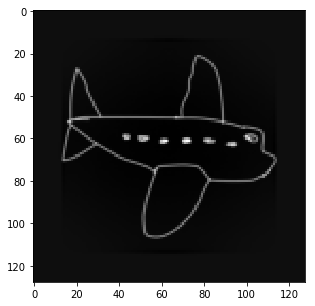

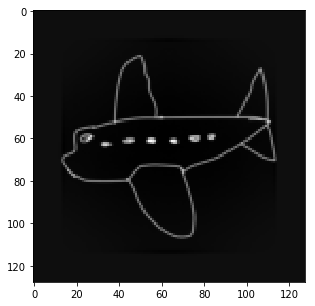

airplane


In [9]:
# Plot a random image
sample = np.random.randint(X_train.shape[0])
sample = 0
plt.imshow(X_train[sample].reshape(128, 128))
plt.show()
plt.imshow(X_train[sample + (1 if sample % 2 == 0 else -1)].reshape(128, 128))
plt.show()
print (labels[y_train[sample]])

In [7]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, res, res, 1])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
lr = tf.placeholder(tf.float32)
reg = tf.placeholder(tf.float32)

y_out = models.resnet_dropout(X, y, layer_depth=3, num_classes=num_classes, is_training=is_training, reg=reg)
print (y_out.shape)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y, num_classes), logits=y_out))
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)
reg_val = 1e-2
learning_rate = 1e-3

(?, 250)


In [8]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
                # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
                        # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:], y: yd[idx], is_training:training_now,
                         lr : learning_rate, reg: reg_val}
                        
                        
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                                                              .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
                              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_losses = []
train_acc = []
val_losses = []
val_acc = []

In [ ]:
epochs = 1
reg_val = 1e-1
learning_rate = 1e-3
for i in range(epochs):
    loss, acc = run_model(session=sess,
                                 predict=y_out,
                                 loss_val=mean_loss,
                                 Xd=X_train,
                                 yd=y_train,
                                 epochs=1,
                                 batch_size=256,
                                 print_every=5,
                                 training=train_step,
                                 plot_losses=False)
    train_losses.append(loss)
    train_acc.append(acc)
    loss, acc = run_model(session=sess,
                                 predict=y_out,
                                 loss_val=mean_loss,
                                 Xd=X_val,
                                 yd=y_val,
                                 epochs=1,
                                 batch_size=64,
                                 print_every=10000,
                                 training=None,
                                 plot_losses=False)
    val_losses.append(loss)
    val_acc.append(acc)

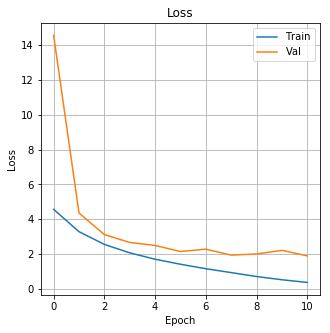

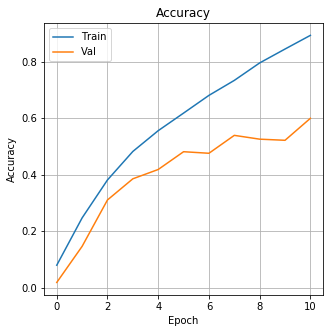

In [8]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.grid(True)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.grid(True)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()